Практическое задание курса ["Введение в Data Science и машинное обучение"](https://stepik.org/lesson/226979/step/2?unit=199528) от Stepik

В данном notebook проводится обучение модели на данных о пользователях курса Stepik с 2015 по 2018 год

Тестирование проводится на данных за первые два дня обучения пользователей, которые проходили курс в период с мая 2018 по январь 2019

Описание данных:

`events_train.csv` - данные о действиях, которые совершают студенты со стэпами

* step_id - id стэпа
* user_id - анонимизированный id юзера
* timestamp - время наступления события в формате unix date
* action - событие, возможные значения: 
    * discovered - пользователь перешел на стэп
    * viewed - просмотр шага,
    * started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
    * passed - удачное решение практического шага
    
`submissions_train.csv` - данные о времени и статусах сабмитов к практическим заданиям

* step_id - id стэпа
* timestamp - время отправки решения в формате unix date
* submission_status - статус решения
* user_id - анонимизированный id юзера

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Настройки для графиков
sns.set(style='whitegrid',
        font_scale=1.2,
        rc={'figure.figsize': (14, 6)})

In [3]:
# Функция для подписи графика
def sets_for_plot(plot, title='', title_fontsize=22, 
                  xlabel='', xlabel_fontsize=18, 
                  ylabel='', ylabel_fontsize=18):
    
    plot.set_title(title, fontsize=title_fontsize)
    plot.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    plot.set_ylabel(ylabel, fontsize=ylabel_fontsize)

# Загрузка и предобработка данных

In [4]:
# Загрузим и отсортируем по дате
events_data = pd.read_csv('event_data_train.csv')
events_data.sort_values('timestamp', inplace=True)

submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data.sort_values('timestamp', inplace=True)

In [5]:
events_data[:10]

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [6]:
submissions_data[:5]

,step_id,timestamp,submission_status,user_id
37939,32929,1434340944,correct,17632
37938,32812,1434341039,correct,17632
39970,32929,1434342105,correct,442
39968,32812,1434342145,wrong,442
39969,32812,1434342156,correct,442


In [7]:
# Проверка пустых значений
events_data.isna().sum()

step_id      0
timestamp    0
action       0
user_id      0
dtype: int64

In [8]:
# Добавление колонок с датой и дата-время
events_data['datetime'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['date'] = events_data.datetime.dt.date

submissions_data['datetime'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['date'] = submissions_data.datetime.dt.date

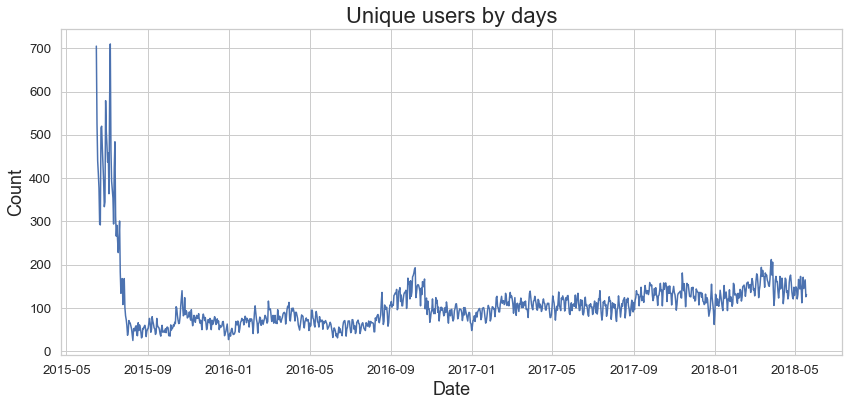

In [9]:
# Уникальные пользователи по дням 
pl = events_data.groupby('date') \
            .user_id.nunique().plot();
sets_for_plot(pl, title='Unique users by days', xlabel='Date', ylabel='Count')

In [10]:
# Для каждого пользователя посчитаем количество по различным действиям
users_events_data = pd.pivot_table(data=events_data,
                                   index='user_id',
                                   columns='action',
                                   values='step_id',
                                   aggfunc='count',
                                   fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [11]:
# Посчитаем для пользователей, которые делали сабмиты их результаты
users_scores = submissions_data.pivot_table(index='user_id',
                                           columns='submission_status',
                                           values='step_id',
                                           aggfunc='count',
                                           fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


### Определим пользователей, которых считаем ушедшими (по какому-нибудь порогу)

In [12]:
# Уникальные дни посещений для каждого пользователя
unique_visits_for_users = events_data[['user_id', 'date', 'timestamp']] \
                                    .drop_duplicates(subset=['user_id','date']) \
                                    .groupby('user_id').timestamp.apply(list)

In [13]:
unique_visits_for_users.head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [14]:
# Разница в днях между ближашими действиями 
timestamps_differences = np.concatenate(unique_visits_for_users.apply(np.diff).values)
timestamps_differences = pd.Series(timestamps_differences)
timestamps_differences = timestamps_differences / (24*60*60)
timestamps_differences

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

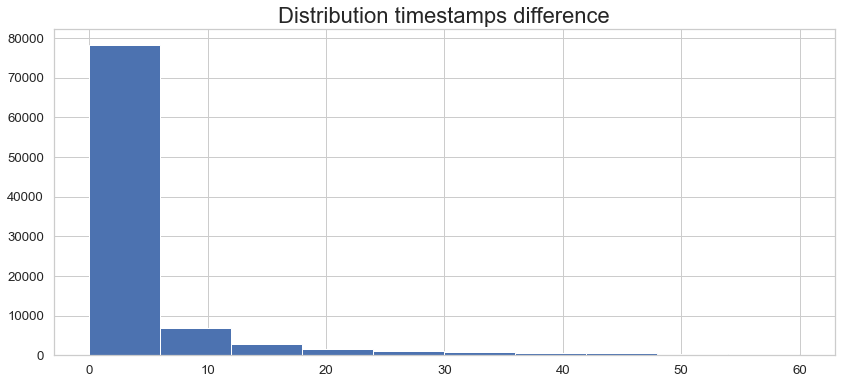

In [15]:
# Рапсределение разницы
hs = timestamps_differences[timestamps_differences < 60].hist()
sets_for_plot(hs, title='Distribution timestamps difference')

In [16]:
# Определим границу после которой будем считать что юзер прекратил обучение
print('90 процентов за границей: ', timestamps_differences.quantile(0.9))
print('95 процентов за границей: ', timestamps_differences.quantile(0.95))

# В качестве порога будем использовать месяц
threshold_drop = 30*24*60*60

90 процентов за границей:  18.325995370370403
95 процентов за границей:  59.760440972222156


In [17]:
# Добавим пользователям метку об их забрасывании курса
users_data = events_data.groupby('user_id', as_index=False) \
                        .agg({'timestamp': 'max'}) \
                        .rename(columns={'timestamp': 'max_timestamp'})

# Максимальная дата (сегодня для того времени)
now = events_data.timestamp.max()
users_data['user_left'] = (now - users_data.max_timestamp) > threshold_drop
users_data.head()

,user_id,max_timestamp,user_left
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


### Определим пользователей прошедших курс

In [18]:
# Примержим данные о сабмитах
users_data = users_data.merge(users_scores, on='user_id', how='outer').fillna(0)
users_data.head()

,user_id,max_timestamp,user_left,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [19]:
# Примержим данные о степах
users_data = users_data.merge(users_events_data, on='user_id', how='outer').fillna(0)
users_data.head(10)

,user_id,max_timestamp,user_left,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
5,8,1481466913,True,9.0,21.0,109,84,37,156
6,9,1484999497,True,0.0,0.0,3,3,0,4
7,11,1526140625,False,0.0,0.0,1,0,1,1
8,14,1436368676,True,0.0,1.0,4,3,1,9
9,16,1513162585,True,77.0,106.0,196,196,108,651


In [20]:
# Если пользователь успешно прошел 170 степов, то считаем его прошедшим курс
users_data['completed_cours'] = users_data.passed > 170
users_data.head()

,user_id,max_timestamp,user_left,correct,wrong,discovered,passed,started_attempt,viewed,completed_cours
0,1,1472827464,True,0.0,0.0,1,0,0,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,False


In [21]:
# Доли по прохождению курса
users_data.completed_cours.value_counts(normalize=True).mul(100).round(2)

False    92.59
True      7.41
Name: completed_cours, dtype: float64

### Данные о количестве уникальных дней для каждого юзера

In [22]:
# Данные об уникальных днях для пользователей
users_days = events_data.groupby('user_id').agg({'date': 'nunique'}) \
                                           .reset_index() \
                                           .rename(columns={'date': 'days_number'})
users_days.head()

,user_id,days_number
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [23]:
# Примержим данные о днях
users_data = users_data.merge(users_days, on='user_id', how='outer').fillna(0)
users_data.head(10)

,user_id,max_timestamp,user_left,correct,wrong,discovered,passed,started_attempt,viewed,completed_cours,days_number
0,1,1472827464,True,0.0,0.0,1,0,0,1,False,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,False,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,False,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,False,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,False,1
5,8,1481466913,True,9.0,21.0,109,84,37,156,False,2
6,9,1484999497,True,0.0,0.0,3,3,0,4,False,1
7,11,1526140625,False,0.0,0.0,1,0,1,1,False,1
8,14,1436368676,True,0.0,1.0,4,3,1,9,False,1
9,16,1513162585,True,77.0,106.0,196,196,108,651,True,21


# Feature engineering

### Отберем данные за n дней

In [24]:
# Количество дней
n_days = 2

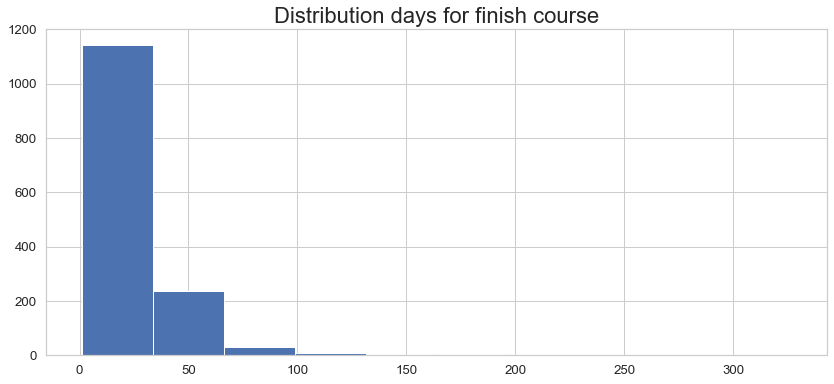

In [25]:
# Распределение значений дней для пользователей, закончивших курс
hs = users_data[users_data.completed_cours==True].days_number.hist()
sets_for_plot(hs, title='Distribution days for finish course')

In [26]:
# Чтобы даты первых дней были одикановы отберем их по events_data

# Находим для каждого юзера первую дату
users_dates_first_action = events_data.groupby('user_id', as_index=False) \
                    .agg({'timestamp': 'min'}) \
                    .rename(columns={'timestamp': 'min_timestamp'})

# Функция, которая отбирает событие за n дней, для каждого юзера
def generate_train_df(df, n_days):
    threshold_days = n_days*24*60*60
    
    # Добавляем эти данные ко всем
    df = df.merge(users_dates_first_action, on='user_id', how='left')
    
    # Отбираем нужные
    df = df[df['timestamp'] <= df['min_timestamp'] + threshold_days]
    
    return df

In [27]:
# Генерируем тренировочную выборку за три дня
events_data_train = generate_train_df(events_data, n_days)
events_data_train.head()

,step_id,timestamp,action,user_id,datetime,date,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [28]:
# Проверка правильности работы
events_data_train.groupby('user_id').date.nunique().max()

3

In [29]:
# Степы, которые были последними с ошибынм решением
submissions_data.drop_duplicates(subset='user_id', keep='last') \
                .query('submission_status == "wrong"') \
                .step_id.value_counts()

31978    154
32812    133
32031     97
32202     92
33481     78
        ... 
33684      1
33676      1
33686      1
32929      1
33674      1
Name: step_id, Length: 72, dtype: int64

In [30]:
submissions_data_train = generate_train_df(submissions_data, n_days)
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,datetime,date,min_timestamp
0,32929,1434340944,correct,17632,2015-06-15 04:02:24,2015-06-15,1434340848
1,32812,1434341039,correct,17632,2015-06-15 04:03:59,2015-06-15,1434340848
2,32929,1434342105,correct,442,2015-06-15 04:21:45,2015-06-15,1434342029
3,32812,1434342145,wrong,442,2015-06-15 04:22:25,2015-06-15,1434342029
4,32812,1434342156,correct,442,2015-06-15 04:22:36,2015-06-15,1434342029


In [31]:
# Проверка правильности работы
submissions_data_train.groupby('user_id').date.nunique().max()

3

### Начнем собирать данные для моделирования

In [32]:
# Данные о количестве уникальных дней
X = submissions_data_train.groupby('user_id').agg({'date': 'nunique'}) \
                                             .reset_index() \
                                             .rename(columns={'date': 'days_number'})
X

,user_id,days_number
0,2,1
1,3,1
2,8,1
3,14,1
4,16,2
...,...,...
8810,26786,1
8811,26787,1
8812,26794,2
8813,26797,1


In [33]:
# Данные о количестве попыток практических степов
X = X.merge(submissions_data_train.groupby('user_id').agg({'step_id': 'nunique'}) \
                                                 .reset_index() \
                                                 .rename(columns={'step_id': 'steps_number'}), 
            on='user_id', how='left')
X

,user_id,days_number,steps_number
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,2,18
...,...,...,...
8810,26786,1,1
8811,26787,1,3
8812,26794,2,22
8813,26797,1,2


In [34]:
# Данные о удачных и неудачных сабмитах
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                                columns='submission_status',
                                values='step_id',
                                aggfunc='count',
                                fill_value=0).reset_index(), 
            on='user_id', how='outer')
X

,user_id,days_number,steps_number,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,2,18,18,23
...,...,...,...,...,...
8810,26786,1,1,1,0
8811,26787,1,3,3,0
8812,26794,2,22,24,7
8813,26797,1,2,2,0


In [35]:
# Доля правильных ответов
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X

,user_id,days_number,steps_number,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,4,4,0.500000
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,2,18,18,23,0.439024
...,...,...,...,...,...,...
8810,26786,1,1,1,0,1.000000
8811,26787,1,3,3,0,1.000000
8812,26794,2,22,24,7,0.774194
8813,26797,1,2,2,0,1.000000


In [36]:
# Данные о действиях юзера за n дней
X = X.merge(events_data_train.pivot_table(index='user_id',
                                           columns='action',
                                           values='step_id',
                                           aggfunc='count',
                                           fill_value=0).reset_index(),
                        on='user_id', how='outer')
X.fillna(0, inplace=True)
X

,user_id,days_number,steps_number,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed
0,2,1.0,2.0,2.0,0.0,1.000000,9,9,2,9
1,3,1.0,4.0,4.0,4.0,0.500000,15,15,4,20
2,8,1.0,11.0,9.0,21.0,0.300000,109,84,37,154
3,14,1.0,1.0,0.0,1.0,0.000000,4,3,1,9
4,16,2.0,18.0,18.0,23.0,0.439024,50,49,21,117
...,...,...,...,...,...,...,...,...,...,...
19229,26781,0.0,0.0,0.0,0.0,0.000000,5,5,0,6
19230,26788,0.0,0.0,0.0,0.0,0.000000,1,1,0,1
19231,26789,0.0,0.0,0.0,0.0,0.000000,2,2,0,2
19232,26790,0.0,0.0,0.0,0.0,0.000000,2,2,0,2


In [37]:
# Данные результаты: прошел курс и не появлялся месяц
X = X.merge(users_data[['user_id', 'user_left', 'completed_cours']],
                        on='user_id', how='outer')
X

,user_id,days_number,steps_number,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed,user_left,completed_cours
0,2,1.0,2.0,2.0,0.0,1.000000,9,9,2,9,True,False
1,3,1.0,4.0,4.0,4.0,0.500000,15,15,4,20,True,False
2,8,1.0,11.0,9.0,21.0,0.300000,109,84,37,154,True,False
3,14,1.0,1.0,0.0,1.0,0.000000,4,3,1,9,True,False
4,16,2.0,18.0,18.0,23.0,0.439024,50,49,21,117,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26781,0.0,0.0,0.0,0.0,0.000000,5,5,0,6,True,True
19230,26788,0.0,0.0,0.0,0.0,0.000000,1,1,0,1,True,False
19231,26789,0.0,0.0,0.0,0.0,0.000000,2,2,0,2,True,False
19232,26790,0.0,0.0,0.0,0.0,0.000000,2,2,0,2,True,False


In [38]:
# Для тренировочного наборы нужны данные есть результат (либо ушел пользователь либо курс завершен)
X = X[X.user_left | X.completed_cours]

In [39]:
# Получились исходы: юзер закончил курс (в этом месяце или нет) и не закончил курс + ушел
X.groupby(['completed_cours', 'user_left']).user_id.count()

completed_cours  user_left
False            True         16560
True             False          141
                 True          1284
Name: user_id, dtype: int64

In [40]:
# юзеров сделаем индексами и разобьем данные на X и y
X = X.set_index(X.user_id)
y = X.completed_cours
X = X.drop(['user_left', 'completed_cours'], axis=1)

In [41]:
X

,user_id,days_number,steps_number,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed
user_id,,,,,,,,,,
2,2,1.0,2.0,2.0,0.0,1.000000,9,9,2,9
3,3,1.0,4.0,4.0,4.0,0.500000,15,15,4,20
8,8,1.0,11.0,9.0,21.0,0.300000,109,84,37,154
14,14,1.0,1.0,0.0,1.0,0.000000,4,3,1,9
16,16,2.0,18.0,18.0,23.0,0.439024,50,49,21,117
...,...,...,...,...,...,...,...,...,...,...
26781,26781,0.0,0.0,0.0,0.0,0.000000,5,5,0,6
26788,26788,0.0,0.0,0.0,0.0,0.000000,1,1,0,1
26789,26789,0.0,0.0,0.0,0.0,0.000000,2,2,0,2


In [42]:
y

user_id
2        False
3        False
8        False
14       False
16        True
         ...  
26781     True
26788    False
26789    False
26790    False
26793    False
Name: completed_cours, Length: 17985, dtype: bool

In [43]:
# Проверка дисбаланса классов
y.value_counts(normalize=True).mul(100)

False    92.076731
True      7.923269
Name: completed_cours, dtype: float64

# ML

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from warnings import filterwarnings
filterwarnings("ignore")

In [45]:
from sklearn import metrics

# Рассчет метрик
def all_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]

    accuracy  = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall    = metrics.recall_score(y_test, y_pred)
    f1_score  = metrics.f1_score(y_test, y_pred)
    roc_auc   = metrics.roc_auc_score(y_test, y_score)
    log_loss  = metrics.log_loss(y_test, y_score)

    print('Accuracy:\t', accuracy)
    print('Precision:\t', precision)
    print('Recall:\t\t', recall)
    print('F1 score:\t', f1_score)
    print('Roc-auc score:\t', roc_auc)
    print('Log-loss:\t', log_loss)
    
    metrics.plot_roc_curve(model, X_test, y_test)
    metrics.plot_precision_recall_curve(model, X_test, y_test)
    metrics.plot_confusion_matrix(model, X_test, y_test, colorbar=False)

In [48]:
# Т.к. классы несбалансированы, то stratify=y
X_train,X_val,y_train,y_val = train_test_split(X, y, 
                                                 test_size=0.25, shuffle=True, 
                                                 random_state=42, stratify=y)
cv = StratifiedKFold(n_splits=3, shuffle=True)

In [52]:
# Логистическая регрессия
lr = LogisticRegression(class_weight = 'balanced')
param_grid = {
    'penalty':  ['l1', 'l2', 'elasticnet'],
    'C'      :  [0.01, 0.1, 1, 10, 100],
    'solver' :  ['sag', 'saga', 'lbfgs']
}

In [53]:
%%time
grid_search_cv_clf = GridSearchCV(lr, param_grid, cv=cv, n_jobs=-1).fit(X_train,y_train)
print(grid_search_cv_clf.best_estimator_)

LogisticRegression(C=0.01, class_weight='balanced')
CPU times: total: 438 ms
Wall time: 2.12 s


In [54]:
model_lr = grid_search_cv_clf.best_estimator_

Accuracy:	 0.7849677562819658
Precision:	 0.22892635314995563
Recall:		 0.7247191011235955
F1 score:	 0.3479433580579906
Roc-auc score:	 0.8213555049667751
Log-loss:	 0.594580438237601


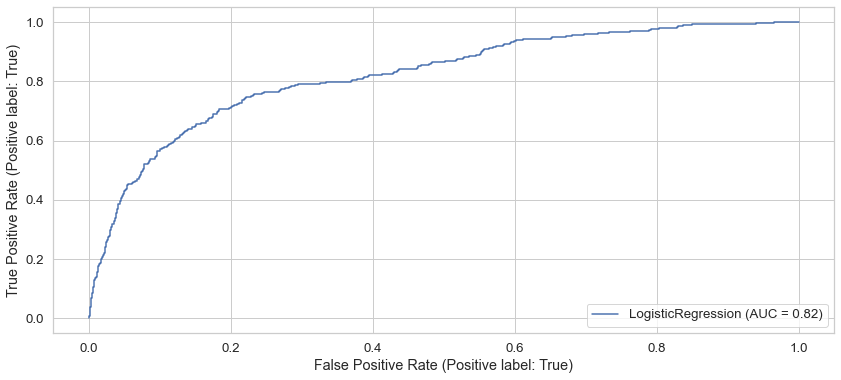

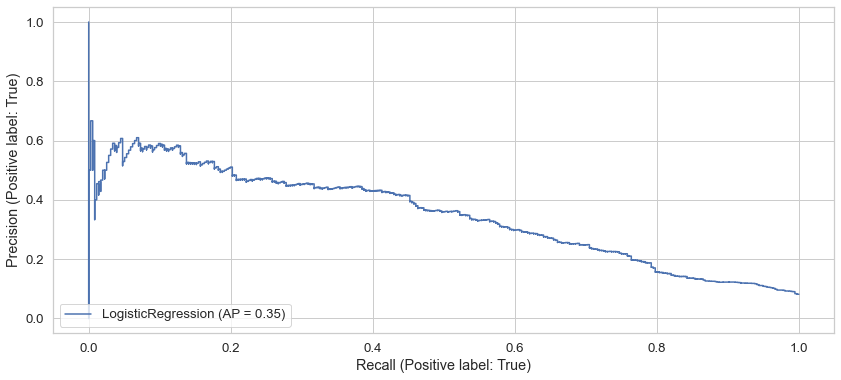

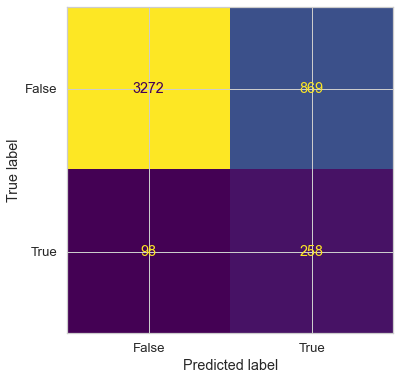

In [56]:
all_metrics(model_lr, X_val, y_val)

In [74]:
# Дерево решений
rf = RandomForestClassifier()
param_grid = {
    'criterion'        : ['entropy', 'gini'], 
    'max_depth'        : range(3, 10), 
    'min_samples_leaf' : np.arange(1, 10, 2),
    'min_samples_split': [2, 25, 50, 75, 100]
}

In [75]:
%%time
grid_search_cv_clf = GridSearchCV(rf, param_grid, cv=cv, n_jobs=-1)
grid_search_cv_clf.fit(X_train,y_train)
grid_search_cv_clf.best_estimator_

CPU times: total: 5.84 s
Wall time: 1min 32s


RandomForestClassifier(max_depth=9, min_samples_leaf=7, min_samples_split=50)

In [76]:
model_rf = grid_search_cv_clf.best_estimator_

Accuracy:	 0.9221703357794085
Precision:	 0.6
Recall:		 0.05056179775280899
F1 score:	 0.0932642487046632
Roc-auc score:	 0.840530024501491
Log-loss:	 0.21257989000522826


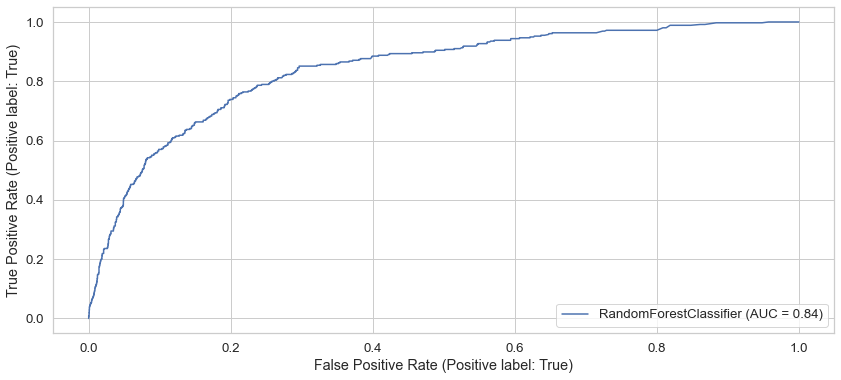

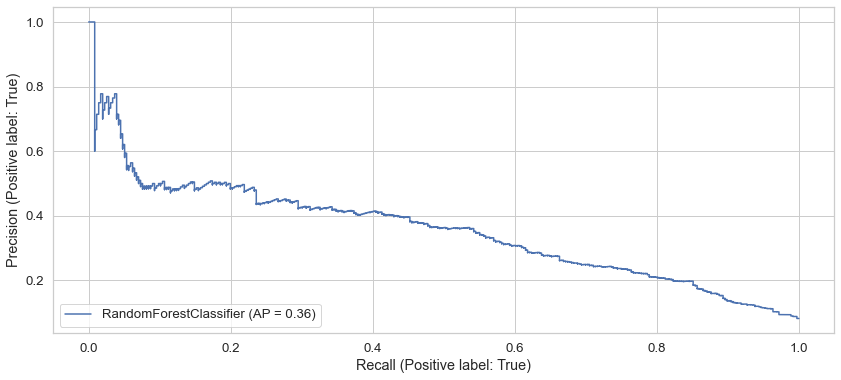

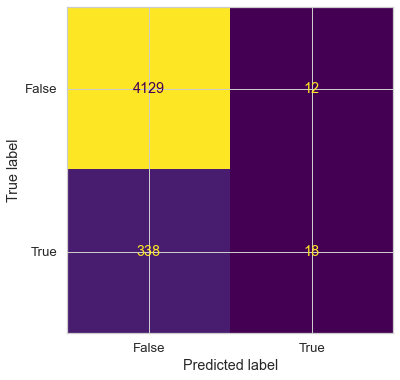

In [77]:
all_metrics(model_rf, X_val, y_val)

In [78]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(15, 25), 
    'leaf_size'  : range(1, 7),
    'weights'    : ['uniform', 'distance']
}

In [79]:
%%time
grid_search_cv_clf = GridSearchCV(knn, param_grid, cv=3, n_jobs=-1)
grid_search_cv_clf.fit(X_train,y_train)
grid_search_cv_clf.best_estimator_

CPU times: total: 1.02 s
Wall time: 9.78 s


KNeighborsClassifier(leaf_size=1, n_neighbors=16)

In [80]:
model_knn = grid_search_cv_clf.best_estimator_

Accuracy:	 0.9206137424949966
Precision:	 0.0
Recall:		 0.0
F1 score:	 0.0
Roc-auc score:	 0.7001416365259436
Log-loss:	 0.8402946613451356


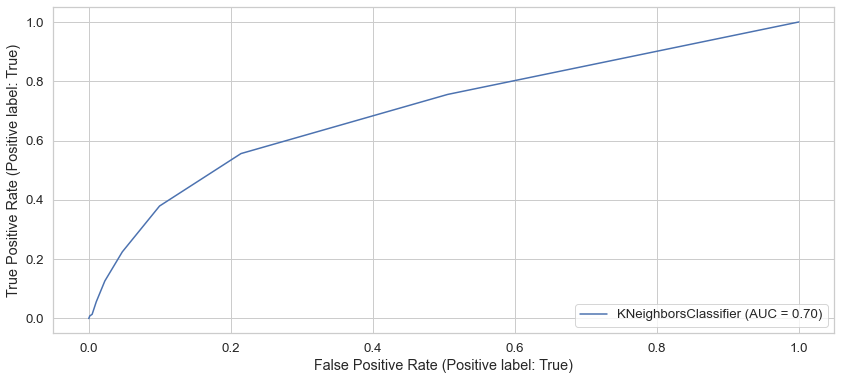

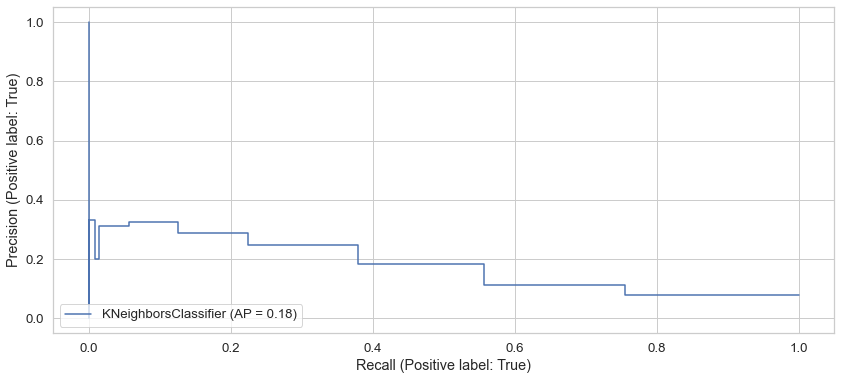

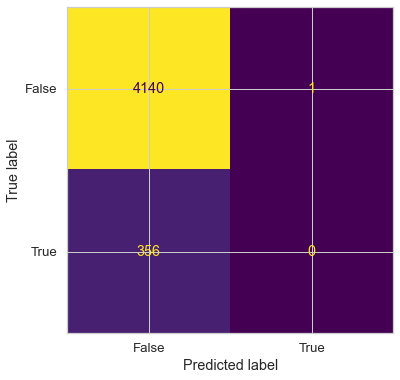

In [81]:
all_metrics(model_knn, X_val, y_val)

Результаты оцениваются по метрике roc-auc. Лучшие результаты дает модель Random forest

# Загрузка тестовых данных и финальные результаты

In [90]:
# Загрузка данных и добавление полей с датами
submission_data_test = pd.read_csv('submission_data_test.csv')
events_data_test = pd.read_csv('events_data_test.csv')

submission_data_test['datetime'] = pd.to_datetime(submission_data_test['timestamp'], unit='s')
events_data_test['datetime'] = pd.to_datetime(events_data_test['timestamp'], unit='s')

submission_data_test['date'] = submission_data_test.datetime.dt.date
events_data_test['date'] = events_data_test.datetime.dt.date

In [91]:
# Генерация дф с фичами
X_test = submission_data_test.pivot_table(index='user_id',
                                             columns='submission_status',
                                             values='step_id',
                                             aggfunc='count')

X_test = X_test.merge(events_data_test.pivot_table(index='user_id',
                                                         columns='action',
                                                         values='step_id',
                                                         aggfunc='count'),
                 on='user_id', how='outer')

X_test = X_test.merge(events_data_test.groupby('user_id', as_index=False)\
                                              .agg({'date': 'nunique'}) \
                                              .rename(columns={'date': 'days_number'}),
                              on='user_id', how='left')

X_test = X_test.merge(submission_data_test.groupby('user_id') \
                                                 .agg({'step_id': 'nunique'}) \
                                                 .reset_index() \
                                                 .rename(columns={'step_id': 'steps_number'}), 
            on='user_id', how='left')

X_test['correct_ratio'] = X_test.correct / (X_test.correct + X_test.wrong)

X_test.fillna(0, inplace=True)

In [92]:
X_test.head()

,user_id,correct,wrong,discovered,passed,started_attempt,viewed,days_number,steps_number,correct_ratio
0,12,1.0,0.0,11.0,9.0,4.0,14.0,1,1.0,0.000000
1,13,29.0,36.0,70.0,70.0,35.0,105.0,2,29.0,0.446154
2,15,10.0,30.0,1.0,1.0,0.0,1.0,1,11.0,0.250000
3,21,24.0,103.0,74.0,68.0,70.0,98.0,2,30.0,0.188976
4,35,7.0,35.0,34.0,30.0,11.0,70.0,3,9.0,0.166667


In [93]:
# Дф с результатами
submissions = pd.DataFrame(users_data.user_id)
submissions['is_gone'] = model_rf.predict_proba(X_test)[:, 1]

In [94]:
# Запись в файл
submissions.to_csv('submissions.csv', sep=',', index=False)

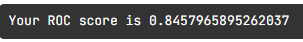